---
title: "Linear Discriminant Analysis and Quadratic Discriminant Analysis"
format: 
  html:
    embed-resources: true
---

In [1]:
# imports
library(leaps) |> suppressPackageStartupMessages() |> suppressWarnings()
library(tidyverse) |> suppressPackageStartupMessages() |> suppressWarnings()
library(dplyr) |> suppressPackageStartupMessages() |> suppressWarnings()
library(glmnet) |> suppressPackageStartupMessages() |> suppressWarnings()
library(MASS) |> suppressPackageStartupMessages() |> suppressWarnings()
library(caret) |> suppressPackageStartupMessages() |> suppressWarnings()
library(ggplot2) |> suppressPackageStartupMessages() |> suppressWarnings()

set.seed(5300)

df <- read.csv("../data/clean/absenteeism_model_final.csv")
df_bss <- read.csv("../data/clean/absenteeism_model_final_bss.csv")
df$high_absenteeism <- factor(df$high_absenteeism, levels = c(0, 1))
df_bss$high_absenteeism <- factor(df_bss$high_absenteeism, levels = c(0, 1))
df$high_absenteeism_doe <- factor(df$high_absenteeism_doe, levels = c(0, 1))
df_bss$high_absenteeism_doe <- factor(df_bss$high_absenteeism_doe, levels = c(0, 1))
head(df)

,high_absenteeism,high_absenteeism_doe,absenteeism_class,total_students,american_indian_alaska_native_pct,asian_pacific_islander_pct,hispanic_pct,black_african_american_pct,white_pct,native_hawaiian_pacific_islander_pct,student_poverty_ratio,total_federal_revenue,total_state_revenue,total_local_revenue,total_expenditures,total_salaries,total_employee_benefits,expenditures_per_student
,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,0,0,2,5767,0.0051,0.0047,0.5637,0.0454,0.3563,0.0003,0.21595855,13132000,42566000,18900000,65734000,18998000,11412000,11398.30
2,0,0,2,5717,0.0055,0.0042,0.2840,0.0145,0.6787,0.0012,0.19651226,24404000,45327000,18823000,87804000,22575000,14775000,15358.40
3,0,0,1,13300,0.0012,0.0744,0.0928,0.2298,0.5542,0.0009,0.07384286,18644000,87393000,113032000,208943000,73899000,40534000,15710.00
4,0,0,1,12187,0.0046,0.0895,0.0844,0.1894,0.5667,0.0016,0.05628474,14037000,85179000,78543000,173520000,49853000,27452000,14238.12
5,1,0,3,2081,0.0009,0.0054,0.1502,0.2555,0.5677,0.0000,0.16944172,5158000,15284000,11143000,28267000,9146000,5064000,13583.37
6,0,0,2,2360,0.0045,0.0065,0.4213,0.0206,0.5071,0.0182,0.17793241,6230000,18456000,8358000,30286000,9510000,5876000,12833.05


### Binary LDA/QDA (Average Ratio - 23.6%)

#### LDA w/ All Features

Linear Discriminant Analysis 

10241 samples
   15 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9217, 9217, 9216, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.6763005  0.3005254

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1262  606
         1  232  459
                                         
               Accuracy : 0.6725         
                 95% CI : (0.654, 0.6907)
    No Information Rate : 0.5838         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.2903         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.8447         
            Specificity : 0.4310         
         Pos Pred Value : 0.6756         
         Neg Pred Value : 0.6643         
             Preva

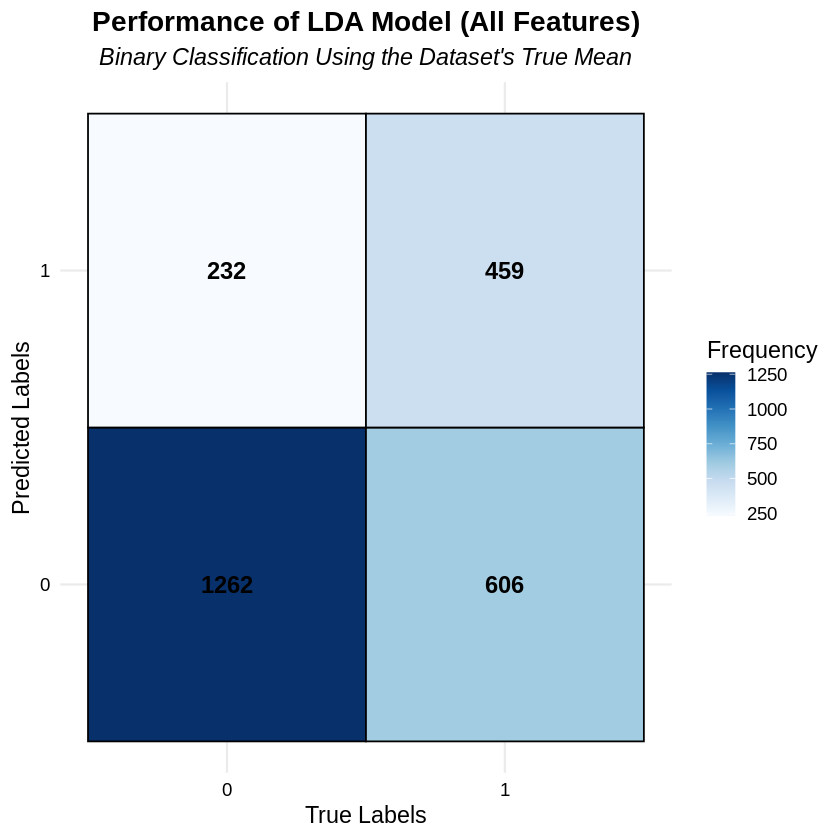

In [2]:
# Keep only numeric columns (as before)
df_subset <- df |>
  dplyr::select(1, 4:18)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset$high_absenteeism, p = 0.8, list = FALSE)
train <- df_subset[train_index, ]
test  <- df_subset[-train_index, ]

# Fit the LDA model with cross-validation
lda.fit1 <- train(
  high_absenteeism ~ ., 
  data = train,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
predictions_one <- predict(lda.fit1, newdata = test, type = "prob")[, "1"]

# Print the model summary
print(lda.fit1)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_one > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism)
print(cm)

# Visualize the confusion matrix
cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (All Features)",
    subtitle = "Binary Classification Using the Dataset's True Mean",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )


This actually results in the same accuracy as the select features. This is probably because it gets rid of the male/female variables as Gentry pointed out in the logistic regression model.

#### Feature Importance

In [3]:
# Extract LDA model object from caret
lda_model <- lda.fit1$finalModel

# View the scaling coefficients (aka linear discriminants)
lda_model$scaling

,LD1
total_students,-5.127120e-06
american_indian_alaska_native_pct,-5.133430e+00
asian_pacific_islander_pct,-9.507333e+00
hispanic_pct,-5.230192e+00
black_african_american_pct,-5.116231e+00
white_pct,-6.659445e+00
native_hawaiian_pacific_islander_pct,5.041587e+00
student_poverty_ratio,7.664718e+00
total_federal_revenue,6.342597e-09
total_state_revenue,3.073842e-09


#### LDA w/ Feature Selection Considerations

Linear Discriminant Analysis 

10241 samples
   12 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9218, 9216, 9217, 9217, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.6744453  0.2969916

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1072  745
         1  422  320
                                          
               Accuracy : 0.544           
                 95% CI : (0.5244, 0.5634)
    No Information Rate : 0.5838          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0188          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7175          
            Specificity : 0.3005          
         Pos Pred Value : 0.5900          
         Neg Pred Value : 0.4313          
    

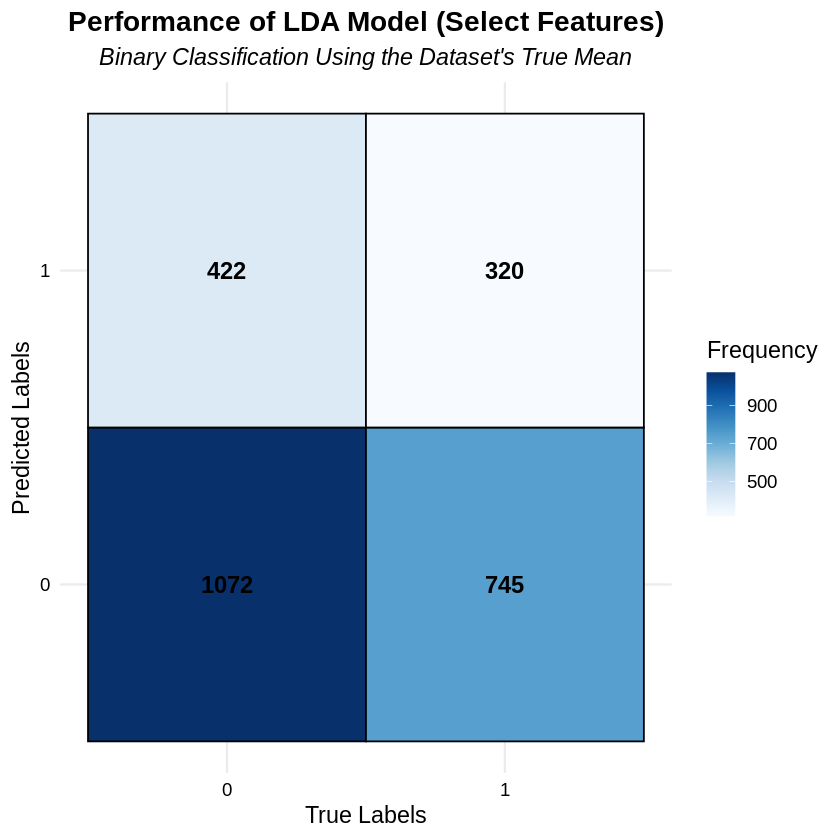

In [4]:
# Keep only numeric columns (as before)
df_subset_select <- df_bss |>
  dplyr::select(1, 4:15)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset_select$high_absenteeism, p = 0.8, list = FALSE)
train_select <- df_subset_select[train_index, ]
test_select  <- df_subset_select[-train_index, ]

# Fit the LDA model with cross-validation
lda.fit2 <- train(
  high_absenteeism ~ ., 
  data = train_select,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
predictions_two <- predict(lda.fit2, newdata = test_select, type = "prob")[, "1"]

# Print the model summary
print(lda.fit2)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_two > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (Select Features)",
    subtitle = "Binary Classification Using the Dataset's True Mean",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

#### Feature Importance

In [5]:
# Extract LDA model object from caret
lda_model <- lda.fit2$finalModel

# View the scaling coefficients (aka linear discriminants)
lda_model$scaling

,LD1
american_indian_alaska_native_pct,-5.479081e+00
asian_pacific_islander_pct,-9.881838e+00
hispanic_pct,-5.593217e+00
black_african_american_pct,-5.642949e+00
white_pct,-7.081906e+00
student_poverty_ratio,7.707318e+00
total_federal_revenue,5.145924e-09
total_state_revenue,2.001611e-09
total_local_revenue,-4.525788e-09
total_expenditures,-8.502581e-11


#### QDA

QDA with all features would not fit, so we use the features derived from the feature selection section (minimizing BIC)

Quadratic Discriminant Analysis 

10241 samples
   15 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9216, 9217, 9218, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.6413452  0.1857219

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1381  813
         1  113  252
                                          
               Accuracy : 0.6381          
                 95% CI : (0.6192, 0.6568)
    No Information Rate : 0.5838          
    P-Value [Acc > NIR] : 1.109e-08       
                                          
                  Kappa : 0.1778          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9244          
            Specificity : 0.2366          
         Pos Pred Value : 0.6294          
         Neg Pred Value : 0.6904          
 

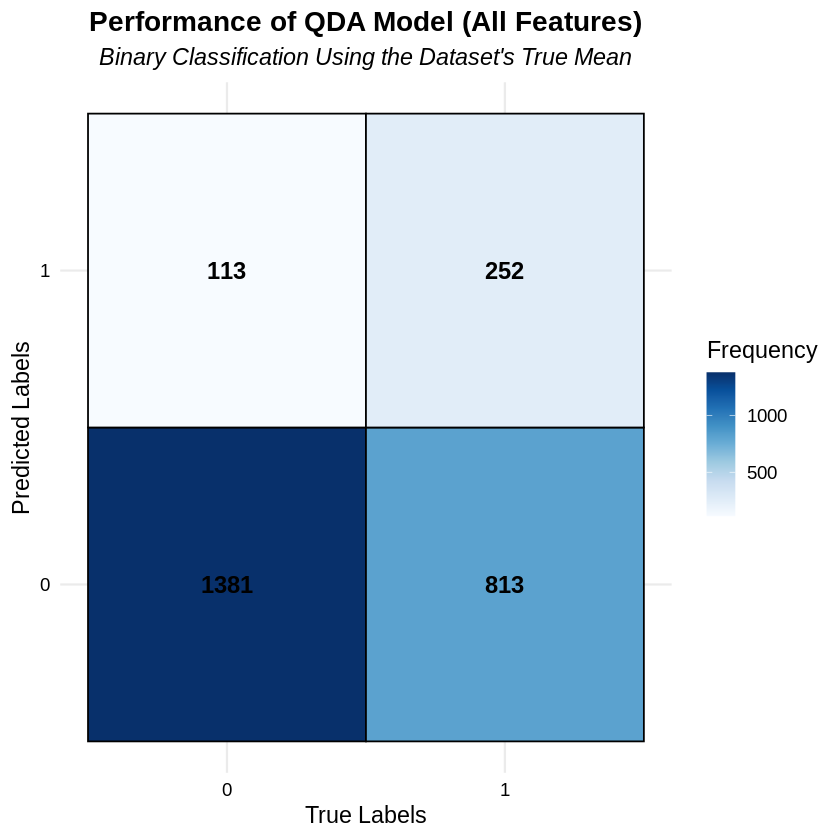

In [6]:
# Fit the QDA model with cross-validation
qda.fit <- train(
  high_absenteeism ~ ., 
  data = train,
  method = "qda",
  trControl = train_control
)

# Make predictions on the test set
predictions_three <- predict(qda.fit, newdata = test, type = "prob")[, "1"]

# Print the model summary
print(qda.fit)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_three > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of QDA Model (All Features)",
    subtitle = "Binary Classification Using the Dataset's True Mean",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

#### Feature Importance

In [7]:
# Extract LDA model object from caret
qda_model <- qda.fit$finalModel

# View the scaling coefficients (aka linear discriminants)
qda_model$means

,total_students,american_indian_alaska_native_pct,asian_pacific_islander_pct,hispanic_pct,black_african_american_pct,white_pct,native_hawaiian_pacific_islander_pct,student_poverty_ratio,total_federal_revenue,total_state_revenue,total_local_revenue,total_expenditures,total_salaries,total_employee_benefits,expenditures_per_student
0,2552.751,0.01672691,0.02672669,0.1409788,0.04255416,0.7309988,0.001389513,0.1236439,4815093,17542583,23825227,46067600,14719078,9280224,20879.43
1,4644.727,0.04077816,0.01690047,0.2136858,0.10086682,0.5769698,0.001974496,0.1827409,13802626,40302458,33252148,85136206,25702780,16766339,21945.17


#### ROC Curve

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



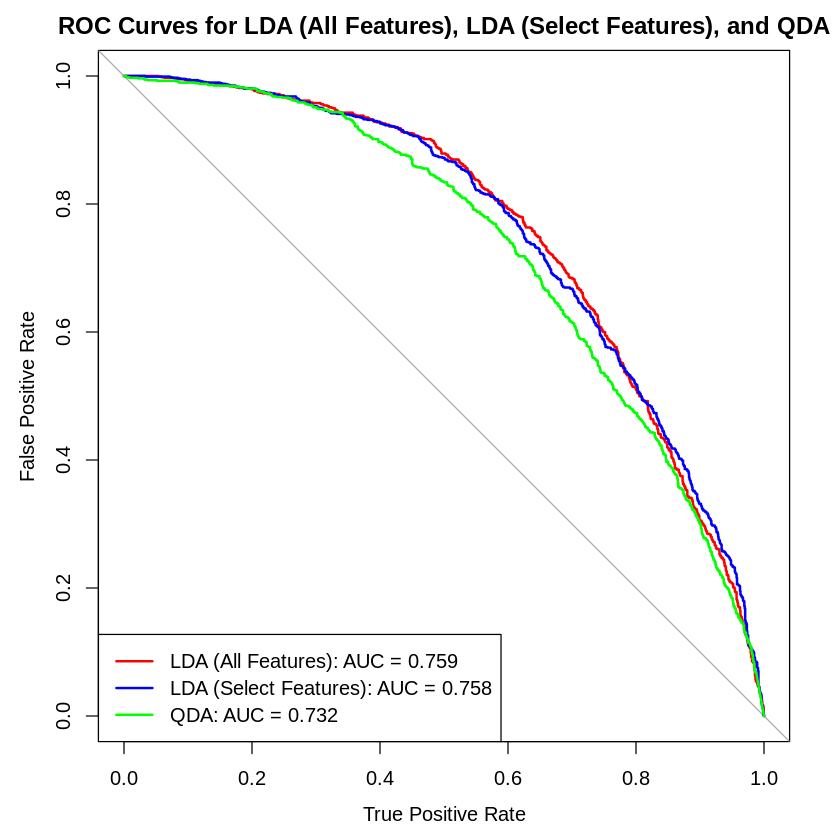

In [8]:
library(pROC)
roc_lda_all <- roc(test$high_absenteeism, predictions_one)
roc_lda_some <- roc(test_select$high_absenteeism, predictions_two)
roc_qda <- roc(test$high_absenteeism, predictions_three)

# Calculate AUC values
auc_lda_all  <- auc(roc_lda_all)
auc_lda_some <- auc(roc_lda_some)
auc_qda      <- auc(roc_qda)

# Plot with flipped axes
plot(roc_lda_all, col = "red", main = "ROC Curves for LDA (All Features), LDA (Select Features), and QDA", 
     xlim = c(0, 1), ylim = c(0, 1), lwd = 2, xlab = "True Positive Rate", ylab = "False Positive Rate")
lines(roc_lda_some, col = "blue", lwd = 2)
lines(roc_qda, col = "green", lwd = 2)

# Add legend with AUC values
legend("bottomleft", legend = c(
    paste("LDA (All Features): AUC =", round(auc_lda_all, 3)),
    paste("LDA (Select Features): AUC =", round(auc_lda_some, 3)),
    paste("QDA: AUC =", round(auc_qda, 3))
  ),
  col = c("red", "blue", "green"), lwd = 2
)

We find that the LDA model with all features performs best in terms of accuracy. However, the model trained on select features is only slightly worse, and the QDA model performs worse with a 0.66 testing accuracy. This suggests an overfit model.

## Binary LDA/QDA (Dept of Ed - 28%)

### LDA (All Features)

Linear Discriminant Analysis 

10241 samples
   15 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9217, 9217, 9217, 9217, 9216, ... 
Resampling results:

  Accuracy   Kappa    
  0.7363538  0.2563762

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1660  529
         1  149  221
                                          
               Accuracy : 0.7351          
                 95% CI : (0.7175, 0.7521)
    No Information Rate : 0.7069          
    P-Value [Acc > NIR] : 0.000866        
                                          
                  Kappa : 0.2493          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9176          
            Specificity : 0.2947          
         Pos Pred Value : 0.7583          
         Neg Pred Value : 0.5973          
    

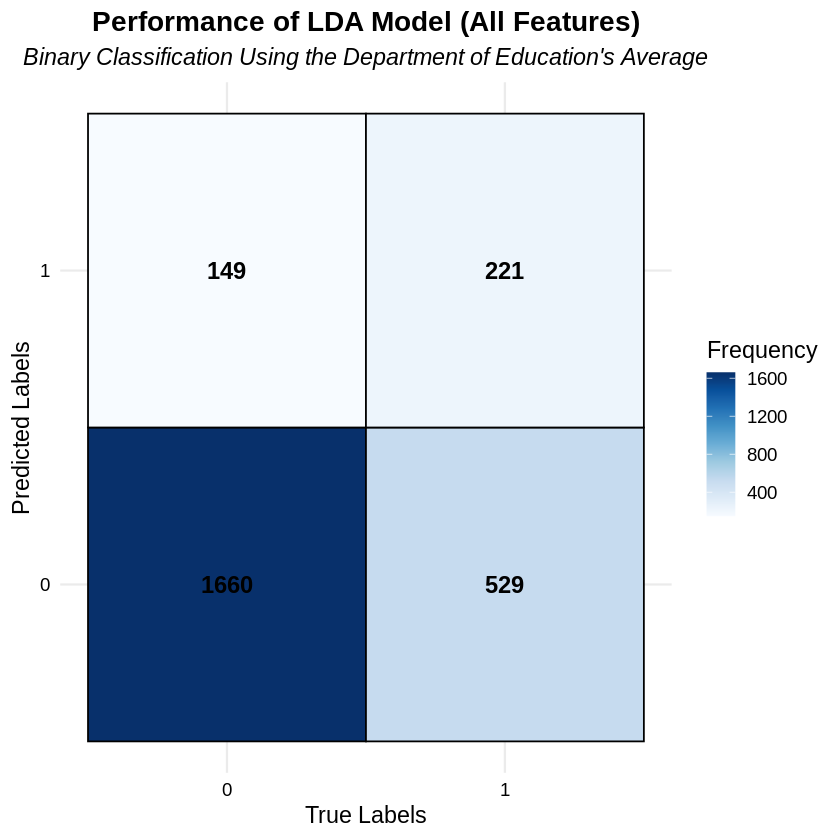

In [9]:
# Keep only numeric columns (as before)
df_subset <- df |>
  dplyr::select(2, 4:18)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset$high_absenteeism_doe, p = 0.8, list = FALSE)
train <- df_subset[train_index, ]
test  <- df_subset[-train_index, ]

# Fit the LDA model with cross-validation
lda.fit1 <- train(
  high_absenteeism_doe ~ ., 
  data = train,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
predictions_one <- predict(lda.fit1, newdata = test, type = "prob")[, "1"]

# Print the model summary
print(lda.fit1)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_one > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism_doe)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (All Features)",
    subtitle = "Binary Classification Using the Department of Education's Average",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

### LDA (Select Features)

Linear Discriminant Analysis 

10241 samples
   12 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9216, 9217, 9217, 9217, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa  
  0.7337162  0.24841

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1581  630
         1  228  120
                                        
               Accuracy : 0.6647        
                 95% CI : (0.646, 0.683)
    No Information Rate : 0.7069        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.0403        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.8740        
            Specificity : 0.1600        
         Pos Pred Value : 0.7151        
         Neg Pred Value : 0.3448        
             Prevalence : 0.7069    

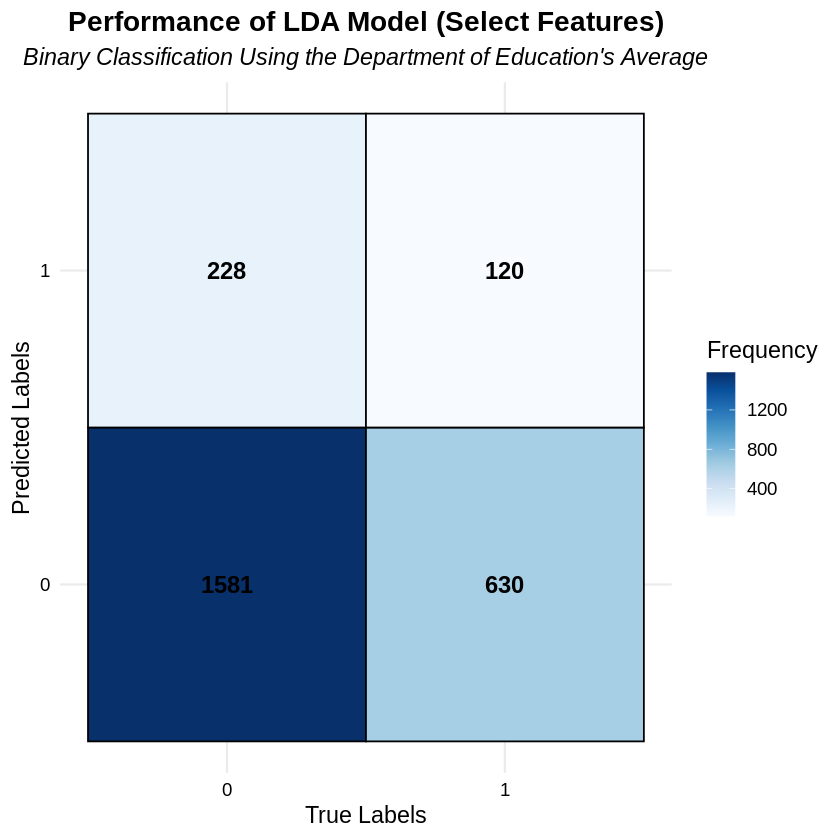

In [10]:
# Keep only numeric columns (as before)
df_subset_select <- df_bss |>
  dplyr::select(2, 4:15)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset_select$high_absenteeism_doe, p = 0.8, list = FALSE)
train_select <- df_subset_select[train_index, ]
test_select  <- df_subset_select[-train_index, ]

# Fit the LDA model with cross-validation
lda.fit2 <- train(
  high_absenteeism_doe ~ ., 
  data = train_select,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
predictions_two <- predict(lda.fit2, newdata = test_select, type = "prob")[, "1"]

# Print the model summary
print(lda.fit2)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_two > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism_doe)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (Select Features)",
    subtitle = "Binary Classification Using the Department of Education's Average",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

### QDA

Quadratic Discriminant Analysis 

10241 samples
   15 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9217, 9217, 9217, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.7252215  0.1957715

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1683  578
         1  126  172
                                          
               Accuracy : 0.7249          
                 95% CI : (0.7071, 0.7421)
    No Information Rate : 0.7069          
    P-Value [Acc > NIR] : 0.02357         
                                          
                  Kappa : 0.1939          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.9303          
            Specificity : 0.2293          
         Pos Pred Value : 0.7444          
         Neg Pred Value : 0.5772          
 

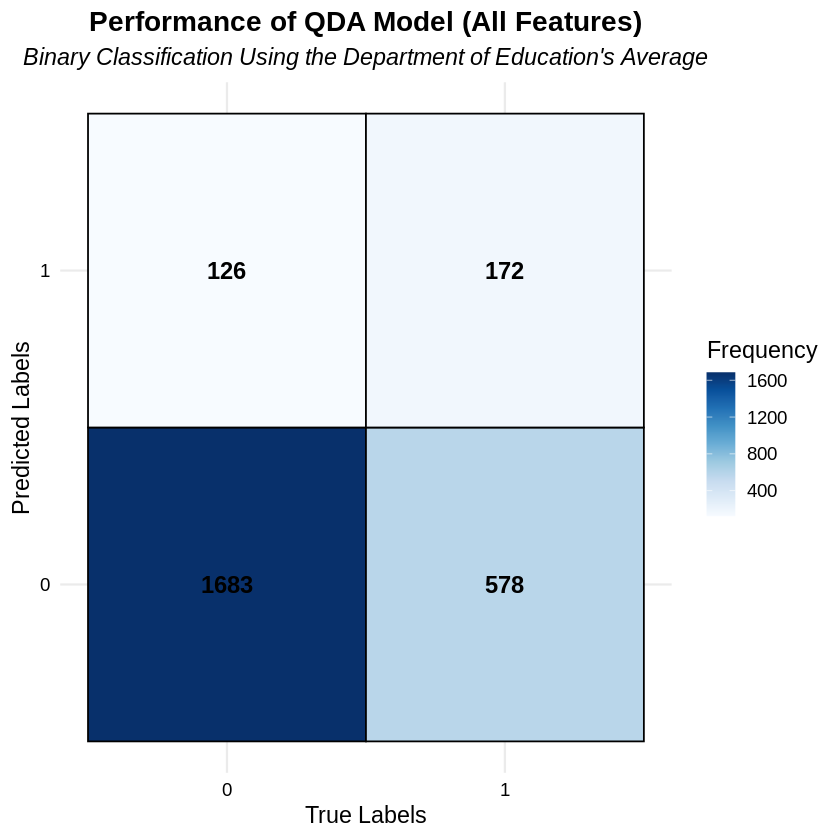

In [11]:
# Fit the QDA model with cross-validation
qda.fit <- train(
  high_absenteeism_doe ~ ., 
  data = train,
  method = "qda",
  trControl = train_control
)

# Make predictions on the test set
predictions_three <- predict(qda.fit, newdata = test, type = "prob")[, "1"]

# Print the model summary
print(qda.fit)

# Convert probabilities to class predictions using a 0.5 threshold
class_preds <- ifelse(predictions_three > 0.5, "1", "0")
class_preds <- factor(class_preds, levels = c("0", "1"))  # ensure same levels as test labels

# Confusion matrix
cm <- confusionMatrix(class_preds, test$high_absenteeism_doe)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of QDA Model (All Features)",
    subtitle = "Binary Classification Using the Department of Education's Average",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

Setting levels: control = 0, case = 1



Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



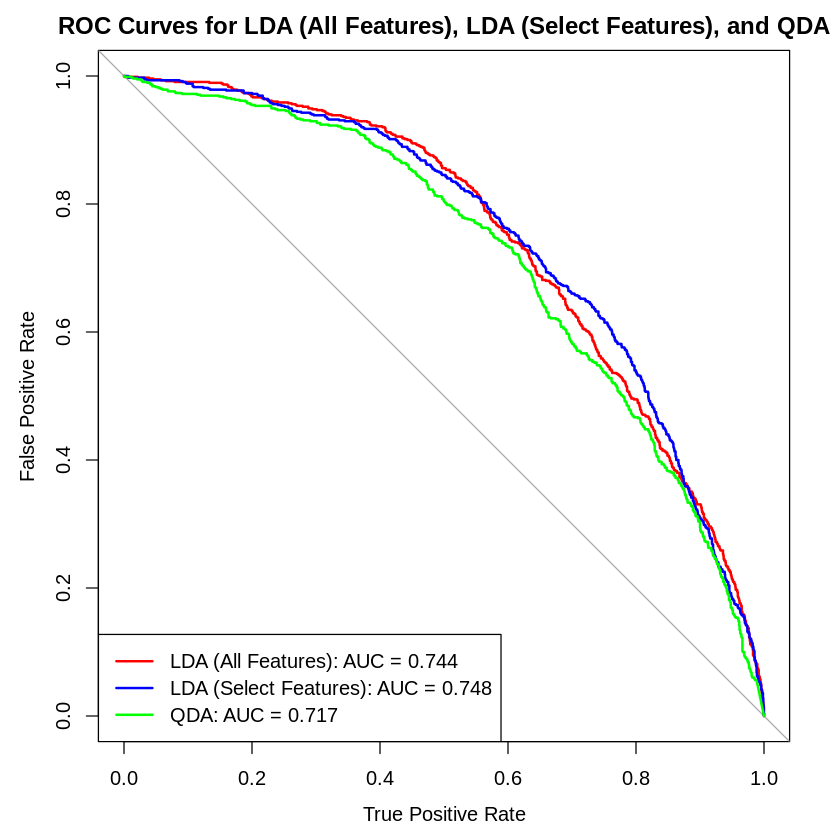

In [12]:
library(pROC)
roc_lda_all <- roc(test$high_absenteeism_doe, predictions_one)
roc_lda_some <- roc(test_select$high_absenteeism_doe, predictions_two)
roc_qda <- roc(test$high_absenteeism_doe, predictions_three)

# Calculate AUC values
auc_lda_all  <- auc(roc_lda_all)
auc_lda_some <- auc(roc_lda_some)
auc_qda      <- auc(roc_qda)

# Plot with flipped axes
plot(roc_lda_all, col = "red", main = "ROC Curves for LDA (All Features), LDA (Select Features), and QDA", 
     xlim = c(0, 1), ylim = c(0, 1), lwd = 2, xlab = "True Positive Rate", ylab = "False Positive Rate")
lines(roc_lda_some, col = "blue", lwd = 2)
lines(roc_qda, col = "green", lwd = 2)

# Add legend with AUC values
legend("bottomleft", legend = c(
    paste("LDA (All Features): AUC =", round(auc_lda_all, 3)),
    paste("LDA (Select Features): AUC =", round(auc_lda_some, 3)),
    paste("QDA: AUC =", round(auc_qda, 3))
  ),
  col = c("red", "blue", "green"), lwd = 2
)

## Multiclass LDA/QDA

#### LDA (All Features)

Linear Discriminant Analysis 

10241 samples
   15 predictor
    3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9216, 9217, 9217, 9217, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.4948743  0.2420815

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 569 392 166
         2 161 226 243
         3 127 236 439

Overall Statistics
                                          
               Accuracy : 0.4822          
                 95% CI : (0.4627, 0.5018)
    No Information Rate : 0.3349          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2231          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6639  0.26464   0.5177
Specificity            0.6722  0.76305   0.787

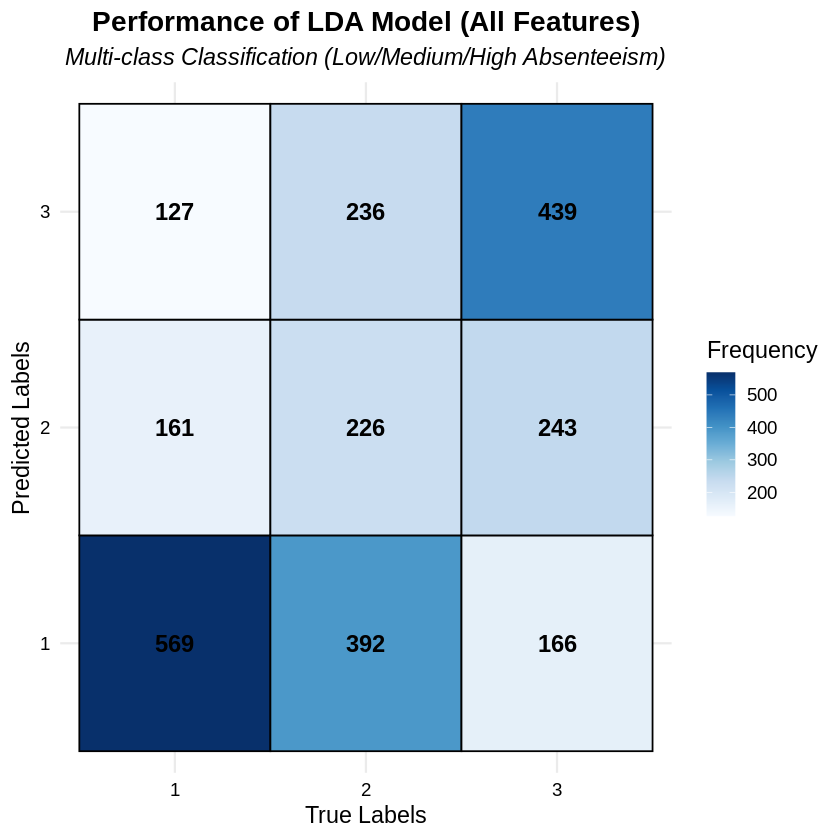

In [13]:
# Keep only numeric columns (as before)
df_subset <- df |>
  dplyr::select(3:18)

# Ensure target is a factor with multiple classes
df_subset$absenteeism_class <- as.factor(df_subset$absenteeism_class)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset$absenteeism_class, p = 0.8, list = FALSE)
train <- df_subset[train_index, ]
test  <- df_subset[-train_index, ]

# Fit the LDA model with cross-validation
lda.fit1 <- train(
  absenteeism_class ~ ., 
  data = train,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
class_preds <- predict(lda.fit1, newdata = test)

# Print the model summary
print(lda.fit1)

# Confusion matrix
cm <- confusionMatrix(class_preds, test$absenteeism_class)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (All Features)",
    subtitle = "Multi-class Classification (Low/Medium/High Absenteeism)",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

#### LDA (Select Features)

Linear Discriminant Analysis 

10241 samples
   12 predictor
    3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9216, 9218, 9217, 9217, 9216, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.4913573  0.2368166

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 416 383 370
         2 196 219 193
         3 245 252 285

Overall Statistics
                                          
               Accuracy : 0.3595          
                 95% CI : (0.3409, 0.3785)
    No Information Rate : 0.3349          
    P-Value [Acc > NIR] : 0.004593        
                                          
                  Kappa : 0.039           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.4854  0.25644   0.3361
Specificity            0.5576  0.77185   0.709

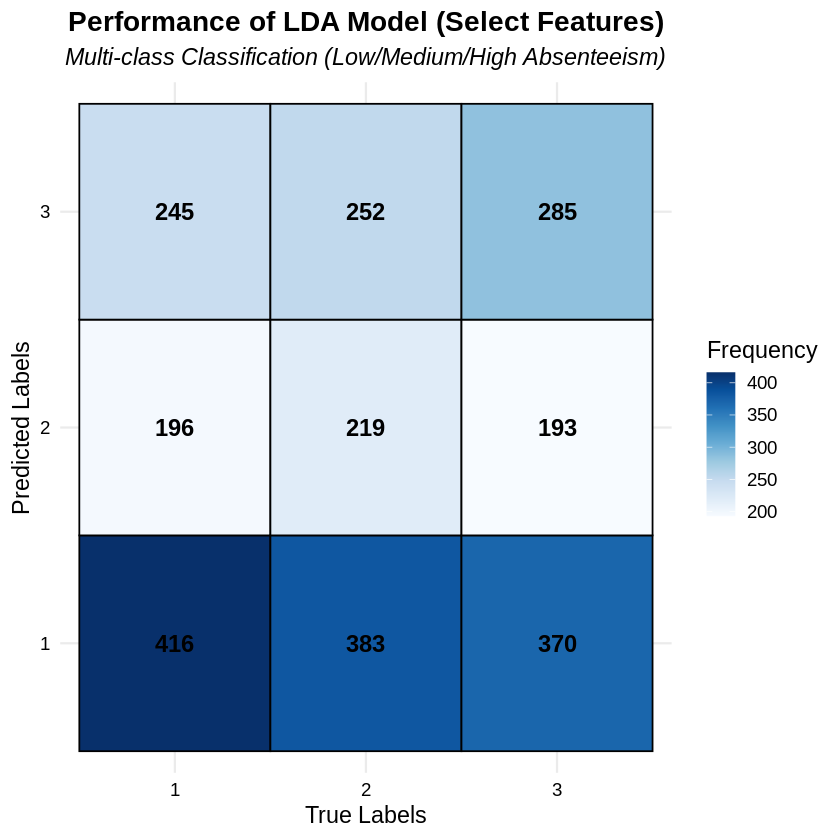

In [14]:
# Keep only numeric columns (as before)
df_subset_select <- df_bss |>
  dplyr::select(3:15)

# Ensure target is a factor with multiple classes
df_subset_select$absenteeism_class <- as.factor(df_subset_select$absenteeism_class)

# Set up cross-validation (10-fold)
train_control <- trainControl(method = "cv", number = 10)

# Split the data into a training and testing set (80/20 split)
train_index <- createDataPartition(df_subset_select$absenteeism_class, p = 0.8, list = FALSE)
train_select <- df_subset_select[train_index, ]
test_select  <- df_subset_select[-train_index, ]

lda.fit2 <- train(
  absenteeism_class ~ ., 
  data = train_select,
  method = "lda",
  trControl = train_control
)

# Make predictions on the test set
class_preds <- predict(lda.fit2, newdata = test_select)

# Print the model summary
print(lda.fit2)

# Confusion matrix
cm <- confusionMatrix(class_preds, test$absenteeism_class)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of LDA Model (Select Features)",
    subtitle = "Multi-class Classification (Low/Medium/High Absenteeism)",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )

#### QDA (All Features)

Quadratic Discriminant Analysis 

10241 samples
   15 predictor
    3 classes: '1', '2', '3' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 9217, 9217, 9217, 9216, 9218, 9217, ... 
Resampling results:

  Accuracy   Kappa    
  0.4132437  0.1184706

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 769 650 479
         2  48 134 202
         3  40  70 167

Overall Statistics
                                          
               Accuracy : 0.4181          
                 95% CI : (0.3989, 0.4375)
    No Information Rate : 0.3349          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1259          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.8973  0.15691  0.19693
Specificity            0.3367  0.85337  0.9

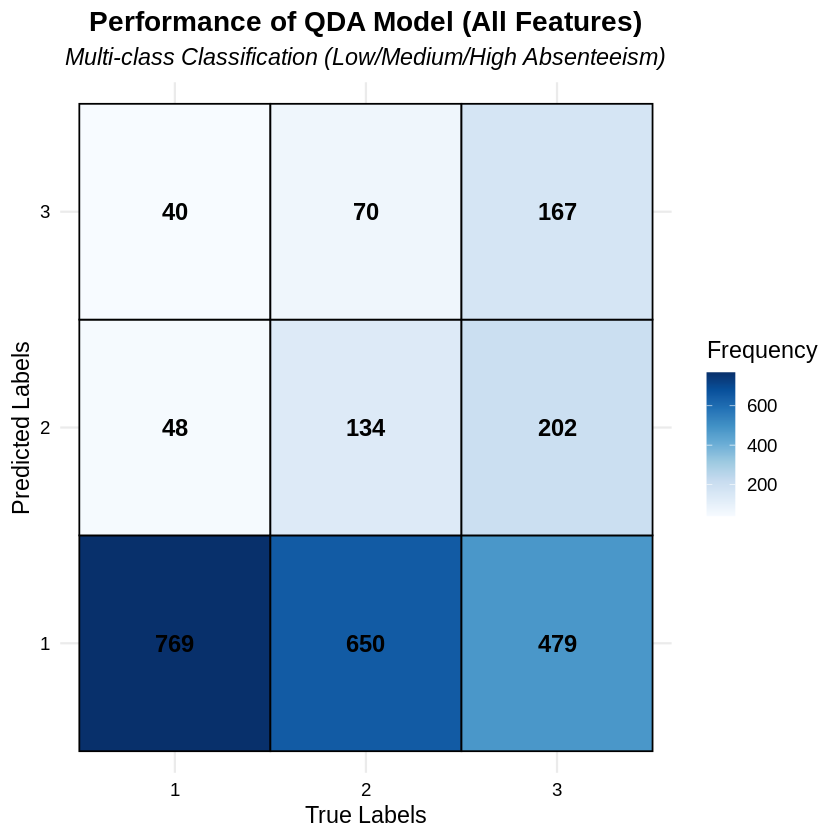

In [15]:
qda.fit <- train(
  absenteeism_class ~ ., 
  data = train,
  method = "qda",
  trControl = train_control
)

# Make predictions on the test set
class_preds <- predict(qda.fit, newdata = test)

# Print the model summary
print(qda.fit)

# Confusion matrix
cm <- confusionMatrix(class_preds, test$absenteeism_class)
print(cm)

# Visualize the confusion matrix

cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "black", lwd = 0.5, linetype = "solid") +  # Add border to tiles
  geom_text(aes(label = Freq), color = "#000000", size = 5, fontface = "bold") +  # Customize text
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(9, "Blues"), name = "Frequency") +  # Use "Blues" theme colors
  labs(
    title = "Performance of QDA Model (All Features)",
    subtitle = "Multi-class Classification (Low/Medium/High Absenteeism)",
    x = "True Labels",
    y = "Predicted Labels"
  ) +
  theme_minimal(base_size = 14) +  # Adjust base font size
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),  # Center and bold title
    plot.subtitle = element_text(hjust = 0.5, face = "italic"),  # Center and italicize subtitle
    axis.text = element_text(color = "black"),  # Customize axis text color
    legend.position = "right"  # Position legend on the right
  )